## Dataset Features

1. timestamp: It contains the exact date and the time moment of the measurement.
2. dt1: rrsi1 was recorded at the time moment timestamp+dt1 . Each measurement contains a burst of 5 consecutive RSS measurements from the iPhone's baseband. System records 5 consecutive RSSIs for many reasons. For example, we can see if the RSS is constant during a few seconds; this will reveal many properties of the wireless channel at the corresponding time moment.
3.dt2: timestamp+dt1+dt2 was the moment when the rssi2 was recorded.
4. and so ...
5. ...
6. ...
7. rssi_ios: RSSI value provided by the iOS private API. rssi_iOS is presented on the iPhone's screen if you press *3001#12345#*. However, iOS software averages rssi1 ... rssi5 during a time interval which is determined internally by the iPhone. Individually, rssi1 ... rssi5 are more accurate since they are provided by the baseband itself through AT commands and they correspond to instantaneous measurements approximately per second (usually dt_i ~=1 sec).
8. rssi1: RSSI, in dBm, read from the iPhone's baseband at timestamp+dt1.
9. rssi2: RSSI, in dBm, read from the iPhone's baseband at timestamp+dt1+dt2.
10. rssi3: RSSI, in dBm, read from the iPhone's baseband at timestamp+dt1+dt3+dt3.
11. rssi4: RSSI, in dBm, read from the iPhone's baseband at timestamp+dt1+dt2+dt3+dt4.
12. rssi5: RSSI, in dBm, read from the iPhone's baseband at timestamp+dt1+dt2+dt3+dt4+dt5.
13. measurementLat: latitude provided by the iPhone's aGPS at the moment timestamp.
14. measurementLon: longitude provided by the iPhone's aGPS at the moment timestamp.
15. finLat: latitude provided by the iPhone's aGPS at the moment timestamp+dt1+dt2+dt3+dt4+dt5
16. finLon: longitude provided by the iPhone's aGPS at the moment timestamp+dt1+dt2+dt3+dt4+dt5. Thus, we can determine if the user was moving during the time interval (timestamp-timestamp+timestamp+dt1+dt2+dt3+dt4+dt5) when the mobile was recording the five consecutive RSSIs.
17.  accur: horizontal accuracy provided by the iPhone's aGPS. Experimentally, we determined that the accuracy provided by the mobile phone was very pessimistic.
18. isMoving: 0 if there is no difference between 13,14 and 15,16. otherwise 1.
19. cellID: the identifier of the cell
19. lac: location area code.
20. mnc: mobile network code, i.e. a specific network provider. For instance, mnc=1 ->Cosmote.
21. arfcn: Absolute radio-frequency channel number.
22. freq_dlink: downlink frequency carrier (calculated by ARFCN).
23. freq_uplin: uplink frequency carrier (calculated by ARFCN).

### Approximate True Location of Cell Tower
35.513226, 24.021793

In [130]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures

from math import ceil, log

def norm_x(x, changedB=False):
    norm_x = np.zeros_like(x)
    if changedB:
        print("mean of RSS: ", np.mean(x[:,6]), ", std of RSS: ", np.std(x[:,6]))
        rssinv = 1/(10**(x[:,6]/10))
        if np.std(rssinv) != 0:
            print("mean of RSS inv (W): ", np.mean(rssinv), ", std of RSS inv (W): ", np.std(rssinv))
            norm_x[:,6] = (rssinv-np.mean(rssinv))/np.std(rssinv)
        else:
            norm_x[:,6] = rssinv
    for col in range(x.shape[1]):
        if not (col == 6 and changedB):
            vals = x[:,col]
            if np.std(vals) != 0:
                norm_x[:,col] = (vals-np.mean(vals))/np.std(vals)
            else:
                norm_x[:,col] = vals
    return norm_x
    
def cell_tower(all_data):
    return np.array([(24.021793-np.mean(all_data[:,13]))/np.std(all_data[:,13]), 
              (35.513226-np.mean(all_data[:,12]))/np.std(all_data[:,12])])

#### NP

def make_gridpoints(x):
        x1min, x1max = np.min(x[:,13]), np.max(x[:,13])
        x2min, x2max = np.min(x[:,12]), np.max(x[:,12])
        testpoints = np.mgrid[x1min:x1max:30j, x2min:x2max:30j].reshape(2,-1).T
        return testpoints

def vandermonde(X, num_features):
    poly = PolynomialFeatures(num_features)
    if X.shape[1] > 2:
        justcoords = np.array([X[:,13], X[:,12]]).T
        return poly.fit_transform(justcoords)
    return poly.fit_transform(X)    

def beta(vandermonde_x, rssinv):
    beta = np.dot(np.linalg.inv(np.dot(np.transpose(vandermonde_x), vandermonde_x)),
                          np.dot(np.transpose(vandermonde_x), np.reshape(rssinv,[rssinv.shape[0],1])))
    return beta
    
def fitmap(data, num_degrees, show=False, cell_tower=None):
    v = vandermonde(data, num_degrees)
    b = beta(v, data[:,6])
    grid = make_gridpoints(data)
    v_grid = vandermonde(grid, num_degrees)
    rssinv_pred = np.dot(v_grid, b)
    if show:

        print("Predicted values are in the range")
        print(np.min(rssinv_pred), np.max(rssinv_pred))
        print("Actual values are in the range")
        print(np.min(data[:,6]), np.max(data[:,6]))
        
        plt.scatter(np.concatenate([grid[:,0], data[:,13]]), 
                    np.concatenate([grid[:,1], data[:,12]]), 
                    c=np.concatenate([rssinv_pred[:,0], data[:,6]]).tolist())
        plt.colorbar()
        plt.scatter(cell_tower[0], cell_tower[1], marker="X", c='red')
    return v, b, grid, v_grid, rssinv_pred

In [2]:
user0 = np.genfromtxt('Chania/1e33.csv', delimiter=',', skip_header=1, converters={0:lambda x: datestr2num(x.decode('UTF-8'))})
user1 = np.genfromtxt('Chania/2222.csv', delimiter=',', skip_header=1, converters={0:lambda x: datestr2num(x.decode('UTF-8'))})
user2 = np.genfromtxt('Chania/6882.csv', delimiter=',', skip_header=1, converters={0:lambda x: datestr2num(x.decode('UTF-8'))})
user3 = np.genfromtxt('Chania/7cbc.csv', delimiter=',', skip_header=1, converters={0:lambda x: datestr2num(x.decode('UTF-8'))})
user4 = np.genfromtxt('Chania/a841.csv', delimiter=',', skip_header=1, converters={0:lambda x: datestr2num(x.decode('UTF-8'))})

In [4]:
user2 = user2[np.where(user2[:,12]>0)]
user2 = user2[np.where(user2[:,6]<0)]
user3 = user3[np.where(user3[:,12]>35.48)]
user0 = user0[np.where(user0[:,6]<0)]

In [5]:
user0 = np.concatenate((user0, np.zeros((len(user0), 1))), axis=1)
user1 = np.concatenate((user1, np.zeros((len(user1), 1))+1), axis=1)
user2 = np.concatenate((user2, np.zeros((len(user2), 1))+2), axis=1)
user3 = np.concatenate((user3, np.zeros((len(user3), 1))+3), axis=1)
user4 = np.concatenate((user4, np.zeros((len(user4), 1))+4), axis=1)

latitude is column 12, longitude is column 13

user id is column 25

Text(0.5, 1.0, 'User locations colored by psuedoID')

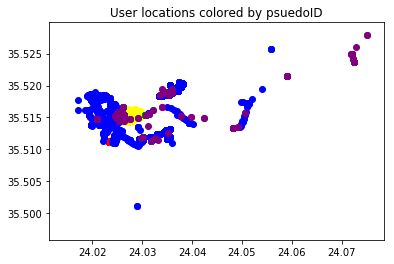

In [82]:
plt.scatter(user0[:,13],user0[:,12],c='red')
plt.scatter(user1[:,13],user1[:,12],c='yellow')
plt.scatter(user2[:,13],user2[:,12],c='green')
plt.scatter(user3[:,13],user3[:,12],c='blue')
plt.scatter(user4[:,13],user4[:,12],c='purple')
plt.title("User locations colored by psuedoID")

In [6]:
all_data = np.concatenate((user0,user1,user2,user3,user4), axis=0)

In [7]:
data_60562 = all_data[np.where(all_data[:,19]==60562)]

In [8]:
norm_all_data = norm_x(all_data, changedB=True)
norm_all_data_not_inverse = norm_x(all_data)
norm_data_60562 = norm_x(data_60562, changedB=True)
norm_data_60562_not_inverse = norm_x(data_60562)

mean of RSS:  -76.79111416604665 , std of RSS:  5.209529083391557
mean of RSS inv (W):  104231527.98389949 , std of RSS inv (W):  728913644.6211451
mean of RSS:  -78.1555882930662 , std of RSS:  3.703891112335958
mean of RSS inv (W):  111964470.39336674 , std of RSS inv (W):  680358558.073076


In [9]:
ct = cell_tower(all_data)
ct_60562 = cell_tower(data_60562)

Text(0.5, 1.0, 'User locations colored by RSS value')

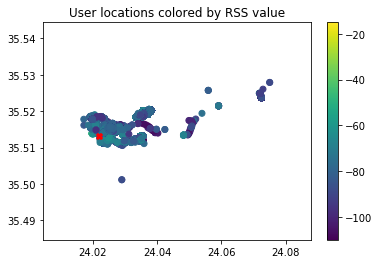

In [83]:
fig = plt.figure()
plt.scatter(all_data[:,13], all_data[:,12],c=all_data[:,6].tolist())
plt.colorbar()
plt.scatter(24.021793, 35.513226, marker="X", c='red')
plt.title("User locations colored by RSS value")

Text(0.5, 1.0, 'User locations colored by RSS value: \n Only signal strengths labeled as cell 60562')

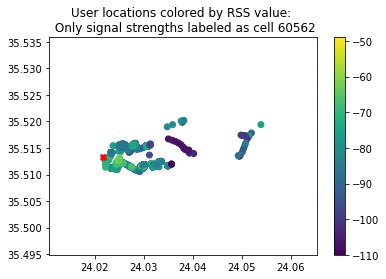

In [84]:
fig = plt.figure()
plt.scatter(data_60562[:,13], data_60562[:,12],c=data_60562[:,6].tolist())
plt.colorbar()
plt.scatter(24.021793, 35.513226, marker="X", c='red')
plt.title("User locations colored by RSS value: \n Only signal strengths labeled as cell 60562")

Predicted values are in the range
-95.83413019916043 -54.92625863314606
Actual values are in the range
-110.0 -15.0



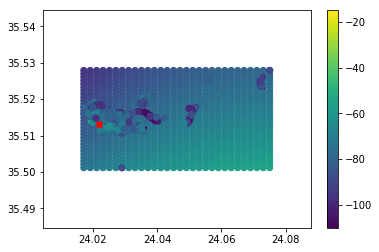

In [79]:
fitmap(all_data, 4, show=True, cell_tower=np.array([24.021793, 35.513226]))
print("")

Predicted values are in the range
-110.09942136512971 2301.3896308164676
Actual values are in the range
-6.374642564109343 11.861170784714925



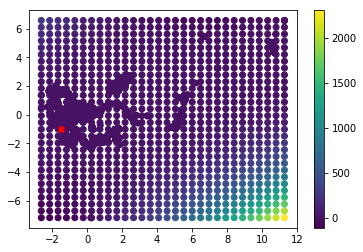

In [80]:
fitmap(norm_all_data_not_inverse, 4, show=True, cell_tower=ct)
print("")

Predicted values are in the range
-380.240274693232 45.90199732283913
Actual values are in the range
-0.14299567188826257 137.04746674612903



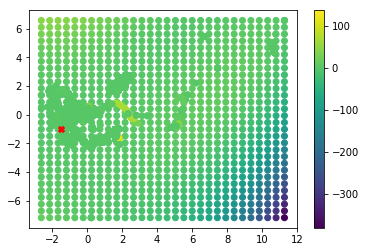

In [81]:
fitmap(norm_all_data, 4, show=True, cell_tower=ct)
print("")

Predicted values are in the range
-83.37708313879557 -46.848882106132805
Actual values are in the range
-110.0 -49.0



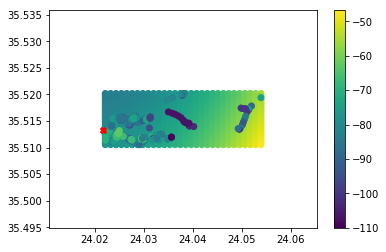

In [74]:
fitmap(data_60562, 4, show=True, cell_tower = np.array([24.021793, 35.513226]))
print("")

Predicted values are in the range
-23.4044636486633 47.005730172293084
Actual values are in the range
-8.597556121689081 7.871610533031694



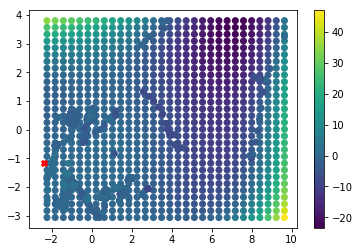

In [75]:
fitmap(norm_data_60562_not_inverse, 4, show=True, cell_tower=cell_tower(data_60562))
print("")

Predicted values are in the range
-889.6723061107597 189.72729389187194
Actual values are in the range
-0.1644501068477439 146.81675470139064



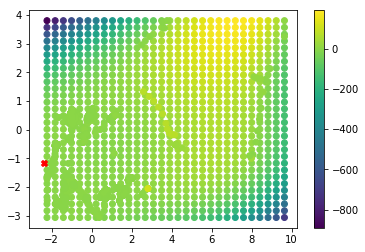

In [76]:
fitmap(norm_data_60562, 4, show=True, cell_tower=cell_tower(data_60562))
print("")

In [170]:
from __future__ import print_function, division

from tensorflow import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    
    def tf_make_gridpoints(self):
            testpoints = np.mgrid[self.x1min:self.x1max:30j, self.x2min:self.x2max:30j].reshape(2,-1).T
            return tf.constant(testpoints, dtype=tf.float32)

    def tf_vandermonde(x, num_features):
        if x.shape[1] > 2:
            i, j = 13, 12
        else:
            i, j = 0, 1
        return tf.transpose(tf.stack([tf.ones_like(x[:,i]),
                                      x[:,i],
                                      x[:,j],
                                      tf.square(x[:,i]),
                                      tf.square(x[:,j]),
                                      tf.multiply(x[:,i], x[:,j]),
                                      tf.multiply(tf.square(x[:,i]), x[:,i]),
                                      tf.multiply(tf.square(x[:,j]), x[:,j]),
                                      tf.multiply(tf.square(x[:,i]), x[:,j]),
                                      tf.multiply(tf.square(x[:,j]), x[:,i]),
                                      tf.multiply(tf.square(x[:,i]), tf.square(x[:,i])),
                                      tf.multiply(tf.square(x[:,j]), tf.square(x[:,j])),
                                      tf.multiply(tf.square(x[:,i]), tf.square(x[:,j])),
                                      tf.multiply(tf.square(x[:,i]), tf.multiply(x[:,i], x[:,j])),
                                      tf.multiply(tf.square(x[:,j]), tf.multiply(x[:,j], x[:,i]))
                                      ]))

    def tf_beta(vandermonde_x, rssinv):
        beta = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(vandermonde_x), vandermonde_x)),
                              tf.matmul(tf.transpose(vandermonde_x), tf.reshape(rssinv,[rssinv.shape[0],1])))
        return beta

    def tf_fitmap(self, data, num_degrees, show=False, cell_tower=None):
        v = tf_vandermonde(data, num_degrees)
        b = tf_beta(v, data[:,6])
        grid = self.tf_make_gridpoints()
        v_grid = tf_vandermonde(grid, num_degrees)
        rss_pred = tf.matmul(v_grid, b)
        return v, b, grid, v_grid, rss_pred
    
    def __init__(self, all_data, norm_all_data):
        self.all_data = all_data
        self.norm_all_data = norm_all_data
        self.input_shape = (32, norm_all_data.shape[1]-1)
        self.x1min, self.x1max, self.x2min, self.x2max = np.min(norm_all_data[:,13]), np.max(norm_all_data[:,13]), np.min(norm_all_data[:,12]), np.max(norm_all_data[:,12])
        
#         optimizer = Adam(0.0002, 0.5)
        optimizer = Adam(lr=0.001, beta_1=0.9)

        self.adversary = self.build_adversary()
        self.adversary.compile(loss=self.adversary_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        self.privatizer = self.build_privatizer()

        x = Input(shape=self.input_shape)
        self.x = x
        y = self.privatizer(x)
        self.y = y

        self.adversary.trainable = False

        uhat = self.adversary(y)

        self.combined = Model(x, uhat)
        self.combined.compile(loss=self.privatizer_loss, 
                              optimizer=optimizer,
                             metrics=['accuracy'])
        
        
    def privatizer_loss(self, u, uhat):
        polynomial_degree = 4
        vx, bx, gridx, v_gridx, rssinv_predx = self.tf_fitmap(self.x[0], polynomial_degree)
        vy, by, gridy, v_gridy, rssinv_predy = self.tf_fitmap(self.y[0], polynomial_degree)
        
        utility_loss = tf.reduce_mean(tf.square(by-bx))        
        privacy_loss = -1*keras.losses.categorical_crossentropy(u, uhat)
        rho = 0.5
        return rho*utility_loss + (1-rho)*privacy_loss
    
    def adversary_loss(self, u, uhat):
        return keras.losses.categorical_crossentropy(u, uhat)

    def build_privatizer(self):

        model = Sequential()

        model.add(Dense(64, input_dim=self.input_shape[1]))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.input_shape[1]))

        # model.summary()
        
        x = Input(shape=self.input_shape)
        y = model(x)

        return Model(x, y)

    def build_adversary(self):

        model = Sequential()
        model.add(Dense(64, input_dim=self.input_shape[1]))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(5, activation='softmax'))
        
        # model.summary()

        y = Input(shape=self.input_shape)
        uhat = model(y)

        return Model(y, uhat)

    def train(self, epochs, adversary_epochs, batch_size=128):

        # load dataset
        X_train = self.norm_all_data[:,:25]
        u = to_categorical(self.all_data[:,25])

        for epoch in range(epochs):

            # Select a random batch
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            X_train_batch = X_train[idx].reshape(1, batch_size, 25)
            self.x = X_train_batch
            u_train_batch = u[idx].reshape(1, batch_size, 5)

            # generate obfuscated data
            Y_batch = self.privatizer.predict(X_train_batch)
            self.y = Y_batch

            # Train the adversary
            self.adversary.trainable = True
            for adversary_epoch in range(adversary_epochs):
                a_loss = self.adversary.train_on_batch(Y_batch, u_train_batch)
            self.adversary.trainable = False
            
            # generate adversary estimates
            uhat_batch = self.adversary.predict(Y_batch)

            # Train the privatizer
            p_loss = self.combined.train_on_batch(X_train_batch, u_train_batch)

            # log the progress
            print ("%d [A loss: %f, acc.: %.2f%%] [P loss: %f, acc.: %.2f%%]" % (epoch, a_loss[0], 100*a_loss[1], p_loss[0], 100*p_loss[1]))

In [171]:
gan = GAN(all_data, norm_all_data_not_inverse)
gan.train(epochs=50, adversary_epochs = 10, batch_size=32)

(32, 15)
(32, 15)
0 [A loss: 0.664130, acc.: 81.25%] [P loss: 374.322266, acc.: 68.75%]
1 [A loss: 0.782904, acc.: 78.12%] [P loss: 237.264984, acc.: 75.00%]
2 [A loss: 0.653963, acc.: 78.12%] [P loss: 327.765137, acc.: 68.75%]
3 [A loss: 0.521670, acc.: 90.62%] [P loss: 129.525513, acc.: 71.88%]
4 [A loss: 0.357404, acc.: 96.88%] [P loss: 1218.681519, acc.: 81.25%]
5 [A loss: 0.149108, acc.: 100.00%] [P loss: 18677.677734, acc.: 90.62%]
6 [A loss: 0.861640, acc.: 78.12%] [P loss: 28.798393, acc.: 68.75%]
7 [A loss: 0.242244, acc.: 93.75%] [P loss: 1861.162109, acc.: 87.50%]
8 [A loss: 0.217949, acc.: 96.88%] [P loss: 1497.459473, acc.: 93.75%]
9 [A loss: 0.234337, acc.: 93.75%] [P loss: 1320.168457, acc.: 75.00%]
10 [A loss: 0.177378, acc.: 96.88%] [P loss: 3003.702637, acc.: 93.75%]
11 [A loss: 0.334461, acc.: 93.75%] [P loss: 200.872437, acc.: 87.50%]
12 [A loss: 0.185354, acc.: 96.88%] [P loss: 4313.520508, acc.: 93.75%]
13 [A loss: 0.224106, acc.: 93.75%] [P loss: 888.974487, acc.